$$\hat{\mathbf{y}}=\mathbf{X} \mathbf{w}+b$$

Most popular loss function in regression is the squared loss 
$$l^{(i)}(\mathbf{w}, b)=\frac{1}{2}\left(\hat{y}^{(i)}-y^{(i)}\right)^{2}$$
The half is just for convenience to cancel the 2 when we take derivative of the loss function.
The empirical risk, or objective function, over the entire dataset of $n$ examples is
$$R(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^{n} l^{(i)}(\mathbf{w}, b)$$
$$R(\mathbf{w},b)=\frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)^{2}$$

We wish to minimize the training model to find the parameters $\mathbf{w}^*, b^*$ that minimize the total loss across all training examples
$$\mathbf{w}^{*}, b^{*}=\underset{\mathbf{w}, b}{\operatorname{argmin}} R(\mathbf{w}, b) .$$

Minibatch gradient descient: first randomly sample a monibatch $B$ consisting of a fixed number of training examples. We first randomly initialize $\mathbf{w}, b$ and then do the following updating
$$
\mathbf{w}  \leftarrow \mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b)=\mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right), $$

$$b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{b} l^{(i)}(\mathbf{w}, b)=b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)$$

$|\mathcal{B}|$ represents the number of examples in the minibatch (batchsize), and $\eta$ is the learning rate.

In [25]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import random

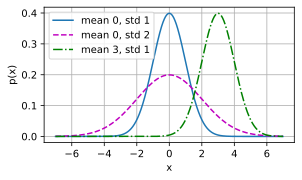

In [10]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Generate data that is $\mathbf{X} \in \mathbb{R}^{1000 \times 2}$, that is, 1000 examples, each consisting of 2 features.
$$\mathbf{w_{True}}=[2,-3.4]^{\top}$$
$$b_{True}=4.2
$$\mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon$$

In [11]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y = y + torch.normal(0, 0.01, size=y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

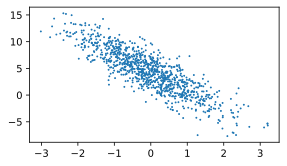

In [18]:
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## Minibatch
The concept of minibatches is fundamental to training any ML model, as discussed the SGD section above. Let's generate data and access them in batches. schematically, the **data_iter** function does the following mapping:

**data_iter :** {features, labels, batch_size}  $\rightarrow$ features[batch_index], labels[batch_index] 

In [19]:
#FUNCTION TO SHUFFLE THE DATA AND ACCESS IT IN MINIBATCHES
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))    
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [23]:
num_examples = len(features)
indices = list(range(num_examples)); indices[:3]

[0, 1, 2]

In [29]:
random.shuffle(indices); indices[:3]

[740, 826, 455]

In [31]:
mylist = [x*x for x in range(3)]
for i in mylist:
    print(i)

0
1
4


mylist is an iterable. Generator is like an iterable, but you can only iterate over it once, and it does not store all the values in memory, the values are generated on the fly

In [36]:
mygenerator = (x*x for x in range(3))
for i in mygenerator:
    print(i)

0
1
4


In [37]:
for i in mygenerator:
    print(i)
#see? we can't iterate over it again

yield is like return, but it returns a generator

In [38]:
def create_generator():
...    mylist = range(3)
...    for i in mylist:
...        yield i*i# basically returns this only once

In [39]:
mygenerator = create_generator() # create a generator
print(mygenerator) # mygenerator is an object!

<generator object create_generator at 0x7fda9c5f2cd0>


In [40]:
for i in mygenerator:
...     print(i)


0
1
4


In [41]:
for i in mygenerator:
...     print(i)


In [42]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [43]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3522,  0.1469],
        [ 2.0474,  2.3505],
        [ 0.0805, -1.2031],
        [ 1.2747, -0.2236],
        [ 0.6648,  0.4004],
        [-1.6671,  0.8839],
        [-1.8273,  0.4832],
        [ 0.2740,  1.7749],
        [-0.3907,  0.8692],
        [-0.7997, -0.5889]]) 
 tensor([[ 4.4193],
        [ 0.2964],
        [ 8.4443],
        [ 7.5169],
        [ 4.1772],
        [-2.1378],
        [-1.1049],
        [-1.3029],
        [ 0.4543],
        [ 4.5905]])


Initialize model parameters

In [46]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w,b

(tensor([[-0.0023],
         [ 0.0014]], requires_grad=True),
 tensor([0.], requires_grad=True))

Define model: here linreg is like Model() block

In [47]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat

In [48]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [49]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent. params for linreg is w, b"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

* Initialize parameters $\mathbf{w}, b$
Repeat until done:
    * compute the gradient of the loss function $\mathbf{g} \leftarrow \partial_{(\mathbf{w}, b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l\left(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b\right)$
    * update the parameters $(\mathbf{w}, b) \leftarrow(\mathbf{w}, b)-\eta \mathbf{g}$ 

In [50]:
lr = 0.03
num_epochs = 3
net = linreg
######## with pytorch
# from torch import nn
# num_input_features = 2
# num_output_features=1
# net = nn.Sequential(nn.Linear(num_input_features, num_output_features))
##############
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025126
epoch 2, loss 0.000084
epoch 3, loss 0.000049


In [51]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0004,  0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0003], grad_fn=<RsubBackward1>)


We can implement a model which has constant parameters, ie those that are not updated (or the gradients of which are not calculated) by the forward function (forward propagation)